VMO: Automatic analysis of repetitive structure using Python
==============================================================

VMO is an ongoing project which uses Python to automatically analyze aspects of repetitive structure in a time-series. Music is one of the interested subject. 

Variable Markov Oracle, an algorithm based on the Factor Oracle string matching algorithm, is used to detect introductions and repetitions of musical materials. Through this analysis, aspects of musical structure can be understood, and new versions of the analyzed work can be created. VMO aims to be a toolbox for exploring this type of automated musical analysis.

An important difference between VMO, FO and AO is that in order to find repetitions in signal data, such as music or other media contents, the signal features between repeating segments are only approximately similar. Accordingly, the main problem for AO is to "tune" its sensibility in a way that it can extact the most amount of information from a signal.

PyOracle has applications for:

+ automated music analysis
+ algorithmic composition
+ machine improvisation

PyOracle is currently implemented as a Python module, and can be used as a stand-alone CL application or embedded in Max or PD through the py/pyext externals.

Building an Variable Markov Oracle using VMO
=======================================

VMO makes it easy to experiment with Oracle structures

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import vmo
import vmo.generate as vge
import librosa
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [3]:
print librosa.__version__

0.6.0


In [4]:
filename = 'prokofiev.wav'
#filename = 'audio_files/ohm_scale.wav'
# filename = '../audioTestFiles/hmmtesttoneNoise.wav'
fft_size = 8192 #8192
hop_size = int(fft_size/2) #256
samplerate = 22050

Extract features from audio file - VMO supports features in arrays directly

(970391,)


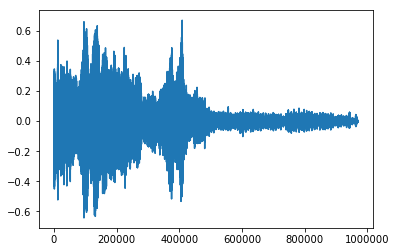

In [6]:
y, sr = librosa.load(filename, sr=samplerate)
print np.shape(y)
plt.plot (y)

In [7]:
# y_harm, y_perc = librosa.effects.hpss(y)
chroma = librosa.feature.chroma_cqt(y, sr = samplerate, hop_length = hop_size)
#chroma = librosa.feature.chroma_stft(y, samplerate, hop_length = hop_size)
features = chroma.T

As an example, plot feature data (a bit of a distorted view, because of the hop size). Matplotlib (part of Numpy/Scipy) makes it easy to do Matlab-style plotting.

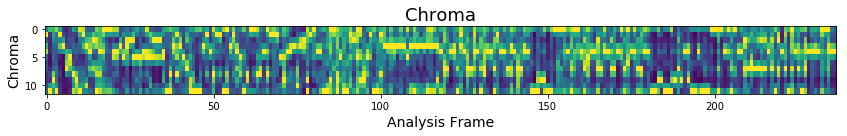

In [8]:
# features is a dictionary, so we can access a particular feature vector with the corresponding key
plt.figure(figsize = (12,2))
plt.imshow(chroma, interpolation = 'nearest', aspect='auto')
plt.title('Chroma', fontsize=18)
plt.xlabel('Analysis Frame', fontsize=14)
plt.ylabel('Chroma', fontsize=14)
plt.tight_layout()

Building an audio oracle from our features:
--

pyoracle.make_oracle() takes arguments for:

* a threshold value for the distance function
* the complete feature vector from the feature extractor
* a string indicating the feature to build the oracle on
* an optional number of feature frames to average

In [9]:
t = 0.5
oracle = vmo.build_oracle(features, flag = 'a',
                          threshold = t,
                          feature = 'chroma', dfunc = 'euclidean', dim=features.shape[1])

Structure of the Audio Oracle
=============
PyOracle uses the *Audio Oracle* (AO) algorithm, which is based on the *Factor Oracle* (FO) string matching structure proposed by Allauzen et al. FO is an acyclic automaton which recognizes all substrings ("factors") in a given string. FO will also sometimes recognize factors which are not part of the original string, but this is not a problem for our application. The structure can be built in an online fashion, i.e. character-by-character, and allows for efficient substring searches. 

 - *Forward transitions* (upper arcs in figures) from state 0 indicate the appearance of a new character, while forward transitions from other states indicate the appearance of sub-factors. 

- *Suffix links* (lower arcs) point backward to the occurence of repeated patterns. The connected states share some common context. The length of the repeated suffix (LRS) is not indicated in this visualization.

So, navigating this oracle structure can allow generation of new patterns which inherit some of the structure of the original sequence. Traveling along forward transitions gives us subfactors (sometimes false) of the original sequence, which jumping back along suffixes allows for creation of new sequences which share a common context.


Changing the number of frames averaged together has an impact on the temporal resolution of the oracle. 

Information Rate
====

Information Rate (IR) is a measure of the reduction in uncertainty about the present given what we know about the past, and is defined as the difference between the unconditional complexity of $x$ and the conditional complexity of $x_n$ given $x_{past}$:

$$ IR(x_{past}, x_n) = C(x_n) - C(x_n | x_{past}) $$

where 

$$ C(\cdot) $$ 

is a compressed version of the oracle and is used to estimate the complexity. It is possible to have multiple suffixes which are varying lengths of the same pattern. We can compress the oracle by keeping only the longest repeated suffixes. The longest repeated suffix (LRS) of a state is the longest suffix of the prefix to a state $i$ that appears at least twice in the prefix. I.e. the longest sequence of states leading up to $i$ that appears at least twice before $i$.

Compression in AO is as follows:

1. We first need the size of the 'alphabet' - this is straight-forward in the symbolic FO, but in AO we use the number of transitions from state 0. Each transition from 0 corresponds to a new state. The number of unique states = size of the alphabet.
2. The number of bits needed to encode that set is $log2(# of transitions from 0)$. This is used as a measure of unconditional complexity, giving us: $C(x_n)$
3. An array $K = [1]$ of encoding events is generated:
    1. If no repetition of $i$ is found, then $sfx(i) = 0$ . This is a new frame, and will need to be individually encoded. It is added to $K$
    2. Otherwise, if a suffix link to an earlier state is found, and the LRS < the number of states since the last encoding event, the entire segment is encoded as $(length, position)$.
4. Using $K$, we can determine $C(x_n|x_{past})$. For every state i, # bits required to represent the state = # bits required to represent the pair (length, position) / length of encoded block.
$$ C(x_n|x_{past}) = \frac{log_2(N) + log_2(M)}{K(i+1) - K(i)} $$ where $M = max(LRS){ }$  and $N$ is sequence length.

Code is an indication of the compressed version of the oracle. Each tuple indicates the number and source of repetitions.

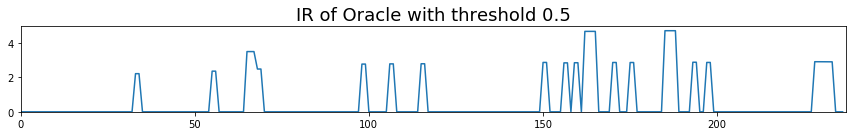

In [10]:
ir, h0, h1 = oracle.IR()
plt.figure(figsize=(12,2))
plt.plot(ir)
plt.ylim((0, max(ir) + 0.25))
plt.xlim((0, len(ir)))
plt.title('IR of Oracle with threshold' + ' ' + str(t), fontsize=18)
plt.tight_layout()

How does IR correspond to the signal? (Might have to adjust number of frames averaged together in Oracle construction...) What about oracles on other features?

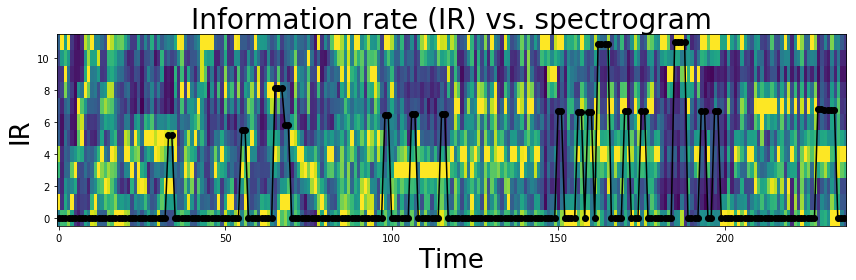

In [11]:
plt.figure(figsize=(12,4))
#stft = np.abs(librosa.core.stft(y=y, n_fft=fft_size, hop_length=hop_size))
#plt.imshow(librosa.logamplitude(stft), interpolation='nearest', aspect='auto', origin='lower')
plt.imshow(chroma, interpolation = 'nearest', aspect='auto',origin='lower')
ir = np.array(ir)
#ir = (ir / ir.max())*4096
ir = (ir / ir.max())*11
#plt.hold('on')
plt.plot(ir,'k-o')
plt.title('Information rate (IR) vs. spectrogram', fontsize=28)
plt.xlabel('Time', fontsize=26)
plt.ylabel('IR', fontsize=26)
plt.axis('tight')
plt.tight_layout()

Above, I chose the oracle distance threshold arbitrarily, but we can use IR to find the 'best' threshold. The total IR value changes as a function of the distance threshold, and we choose the threshold which yields maximum IR.

In [12]:
r = (0., 2.0, 0.05)
ideal_t = vmo.find_threshold(features, r = r, flag = 'a', dfunc = 'euclidean', dim=features.shape[1])

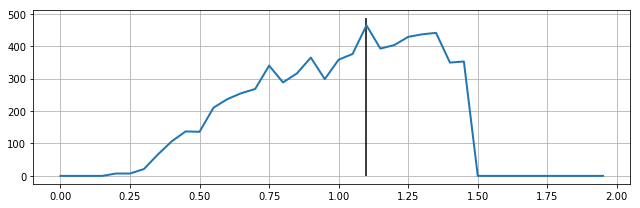

In [13]:
x_t = np.array([t[1] for t in ideal_t[1]])
y_t = [t[0] for t in ideal_t[1]] 
plt.figure(figsize = (9,3))
plt.plot(x_t, y_t, linewidth = 2)
ymin, ymax = plt.ylim()
plt.vlines(ideal_t[0][1], 0, ymax)
plt.grid('on')
plt.tight_layout()

In [14]:
# best threshold is
ideal_t[0]

(464.67043488306001, 1.1000000000000001)

So now, in theory, this is the best oracle.

In [15]:
best_oracle = vmo.build_oracle(features, flag = 'a',
                          threshold = ideal_t[0][1],
                          feature = 'chroma', dfunc = 'euclidean', dim=features.shape[1])

This oracle seems to correspond more closely to the binary form of the Prokofiev work.

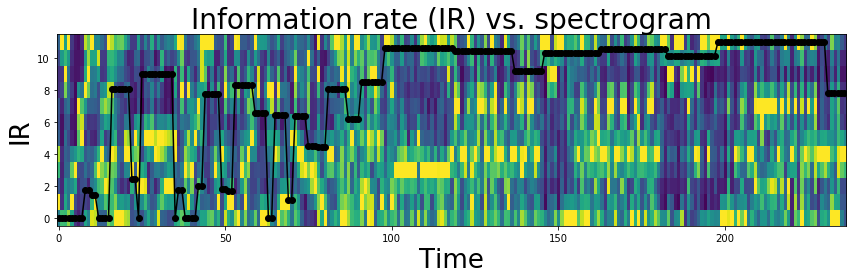

In [16]:
ir, h0, h1 = best_oracle.IR()
plt.figure(figsize=(12,4))
#stft = np.abs(librosa.core.stft(y=y, n_fft=fft_size, hop_length=hop_size))
#plt.imshow(librosa.logamplitude(stft), interpolation='nearest', aspect='auto', origin='lower')
plt.imshow(chroma, interpolation = 'nearest', aspect='auto',origin='lower')
ir = np.array(ir)
#ir = (ir / ir.max())*4096
ir = (ir / ir.max())*11
#plt.hold('on')
plt.plot(ir,'k-o')
plt.title('Information rate (IR) vs. spectrogram', fontsize=28)
plt.xlabel('Time', fontsize=26)
plt.ylabel('IR', fontsize=26)
plt.axis('tight')
plt.tight_layout()

Recomposing / Recombining analyzed music using VMO
====

To generate new output, the oracle is navigated state-by-state, and either continues linearly (with probability *p*) or jumps along a transition / suffix link (*1-p*).

In [19]:
ln = 1000
x = vge.generate_audio('prokofiev.wav', 'out1.wav', best_oracle, ln, samplerate, fft_size, hop_size, p=0.9, k=120, lrs=5)
#vge.generate_audio('audio_files/prokofiev.wav', 'out2.wav', best_oracle, ln, samplerate, fft_size, hop_size, p=0.7, k=0, lrs=2)
#vge.generate_audio('audio_files/prokofiev.wav', 'out3.wav', best_oracle, ln, samplerate, fft_size, hop_size, p=0.5, k=0, lrs=2)

In [50]:
help(vge.generate_audio)

Help on function generate_audio in module vmo.generate:

generate_audio(ifilename, ofilename, oracle, seq_len, analysis_sr=44100, buffer_size=8192, hop=4096, p=0.5, k=0, lrs=0)
    :param ifilename: input audio file path.
    :param ofilename: output audio file path.
    :param oracle: an oracle indexed on ifilename
    :param seq_len: length of sequence to be generated, in frames.
    :param analysis_sr: the sampling frequency of the ifilename.
    :param buffer_size: should match fft/frame size of oracle analysis.
    :param hop: hop size, should be 1/2 the buffer_size.
    :param p: continuity parameter.
    :param k: start frame number.
    :param lrs: the length of minimum longest repeated suffixes allowed to jump
    :return: the improvised sequence in audio wave file

